In [1]:
# 필요한 라이브러리 설치 (터미널에서 실행)
# !pip install transformers pandas scikit-learn matplotlib

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

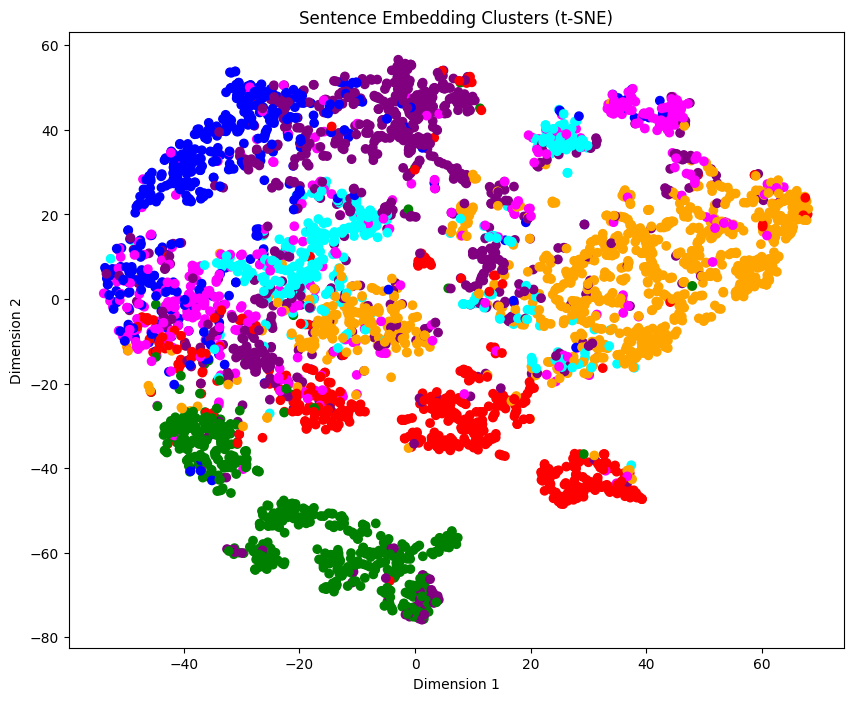

In [30]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 데이터 로드
df = pd.read_csv('../data/preprocessed/asterisk2recover_Tnoise.csv')
df2 = pd.read_csv('../data/preprocessed/asterisk2Tnoise.csv')
df2_id = df2['ID'].tolist()
df = df[df['ID'].isin(df2_id)]

df = pd.read_csv("/data/ephemeral/home/level2-nlp-datacentric-nlp-09/data/exp/train_concat_v15.csv")

# 2번 모델을 SentenceTransformer로 로드
model = SentenceTransformer("dragonkue/bge-m3-ko")

# 문장 임베딩 생성
sentences = df['text'].tolist()  # 텍스트 컬럼에서 문장 리스트 추출
embeddings = model.encode(sentences, show_progress_bar=True)  # 문장 리스트로 임베딩 생성

# 차원 축소 (PCA로 7차원으로 축소 후 t-SNE 적용)
pca = PCA(n_components=7)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# 라벨 컬러 매핑 (0부터 6까지)
label_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4: 'orange', 5: 'cyan', 6: 'magenta'}
colors = df['target'].map(label_colors)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colors)

plt.title("Sentence Embedding Clusters (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


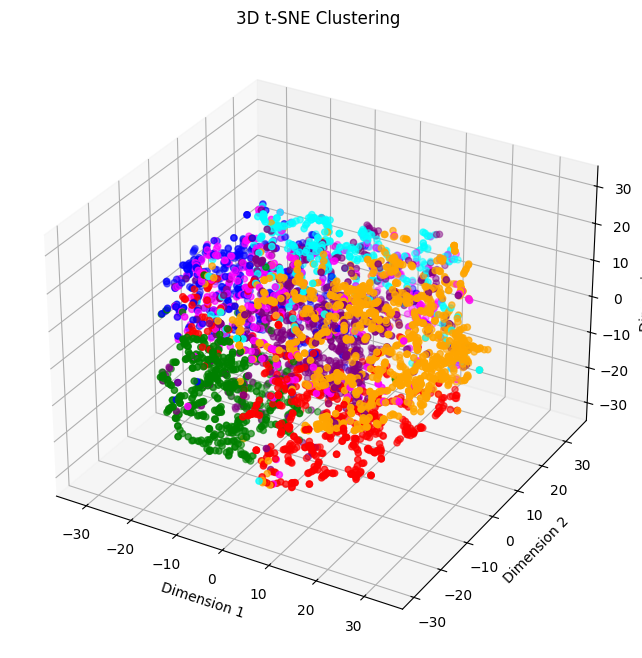

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# 3D t-SNE 변환
tsne_3d = TSNE(n_components=3, perplexity=5, random_state=42)
embeddings_tsne_3d = tsne_3d.fit_transform(embeddings_pca)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 라벨 컬러 매핑
label_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4: 'orange', 5: 'cyan', 6: 'magenta'}
colors = df['target'].map(label_colors)

# 산점도 생성
ax.scatter(embeddings_tsne_3d[:, 0], embeddings_tsne_3d[:, 1], embeddings_tsne_3d[:, 2], c=colors)

ax.set_title("3D t-SNE Clustering")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()


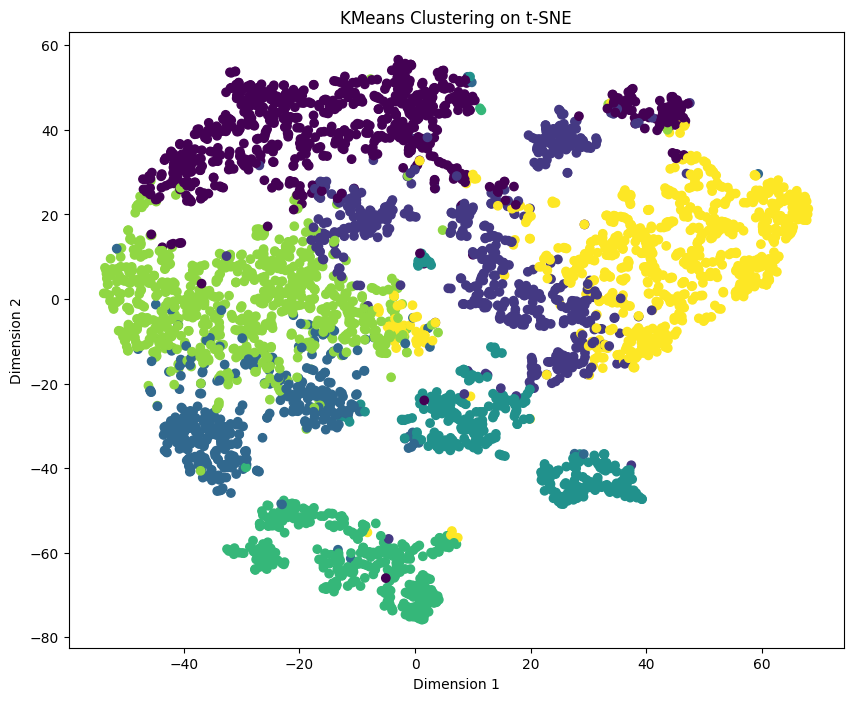

In [31]:
from sklearn.cluster import KMeans

# KMeans 클러스터링
n_clusters = len(df['target'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.title("KMeans Clustering on t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



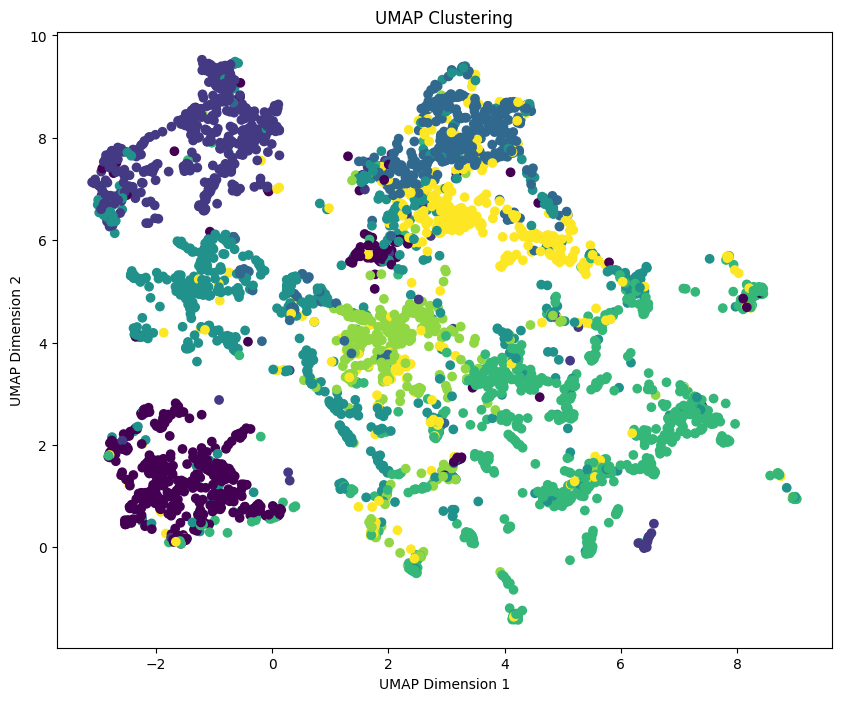

In [32]:
import umap.umap_ as umap  # UMAP 라이브러리 로드

# UMAP 변환
umap_2d = umap.UMAP(n_components=2, random_state=42)
embeddings_umap_2d = umap_2d.fit_transform(embeddings)


# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_umap_2d[:, 0], embeddings_umap_2d[:, 1], c=df['target'], cmap='viridis')
plt.title("UMAP Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


Number of clusters found: 22
Noise points: 4130


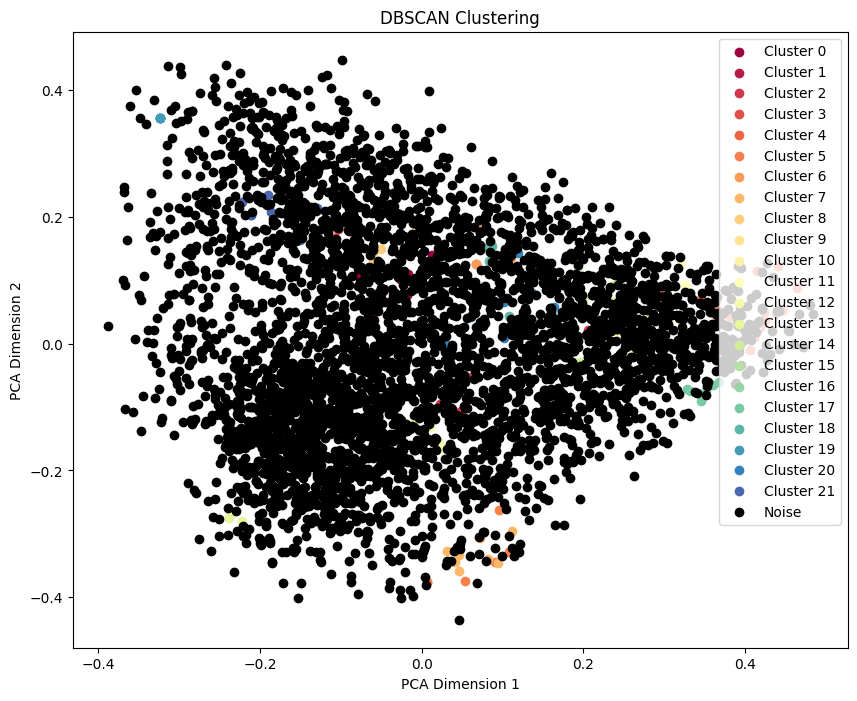

In [33]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# DBSCAN 하이퍼파라미터 설정
eps = 0.5  # 데이터 포인트가 동일 클러스터로 간주되는 거리
min_samples = 5  # 각 클러스터가 최소 포함해야 할 샘플 수

# DBSCAN 모델 생성 및 클러스터링 적용
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(embeddings)

# 클러스터링 결과 요약 출력
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found: {num_clusters}")
print(f"Noise points: {list(dbscan_labels).count(-1)}")

# 차원 축소 (PCA로 2차원 축소 후 시각화)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(10, 8))
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 노이즈 포인트는 회색으로 표시
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)
    xy = embeddings_2d[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], color=tuple(col), label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title("DBSCAN Clustering")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()
